In [47]:
from cirq.contrib.svg import SVGCircuit
from sklearn.datasets import fetch_openml
from mnist import MNISTData

import cirq
import numpy as np
import tensorflow_quantum as tfq
import tensorflow as tf

seed = 42
tf.random.set_seed(seed)

In [200]:
# Declare a QKS layer that extends the keras Layer
class TwoQubitQKSAnsatzLayer(tf.keras.layers.Layer):
    def __init__(self, qubits, uniform_min_value=0.0, uniform_max_value=2.0 * np.pi, stddev=0.1):
        super(TwoQubitQKSAnsatzLayer, self).__init__()
        self.q = 2 # because two qubits, variable names q, p, r are the same as in Wilson et al.
        self.stddev = tf.Variable(initial_value=stddev, trainable=True)
        self.uniform_min_value = 0.0
        self.uniform_max_value = 2.0 * np.pi
        self.qubits = qubits
    
    def build(self, input_shape):
        # creates a mask, which will stay contant throught
        batch_size, p = input_shape
        r = int(p/self.q)
        ones, mask = np.ones((self.q * batch_size, p)), np.random.randint(0, 2, self.q * input_shape[0])
        ones[mask==0,:r], ones[mask==1,r:] = 0.0, 0.0
        self.mask = ones.reshape((batch_size, self.q, p))
    
    def _ansatz(self, theta):
        theta = theta.numpy()
        circuit = cirq.Circuit()
        circuit.append(cirq.rx(theta[0])(self.qubits[0]))
        circuit.append(cirq.rx(theta[1])(self.qubits[1]))
        circuit.append(cirq.CNOT(self.qubits[0], qubits[1]))
        return circuit
    
    def call(self, input):
        batch_size, p = input.shape
        omega = tf.random.normal((batch_size, self.q, p), mean=0.0, stddev=self.stddev) * self.mask
        beta = tf.random.uniform((batch_size, self.q), self.uniform_min_value, self.uniform_max_value)
        
        parameters = tf.keras.backend.batch_dot(input, omega, axes=(1, 2)) + beta
        return tfq.convert_to_tensor([self._ansatz(param) for param in parameters])

In [201]:
qubits = cirq.GridQubit.rect(1,2)
qks_ansatz = TwoQubitQKSAnsatzLayer(qubits)

In [202]:
qks_ansatz.trainable_variables

[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.1>]

In [205]:
data = tf.random.normal((5, 10), mean=0.0, stddev=1.0)
qks_ansatz(data).shape

TensorShape([5])

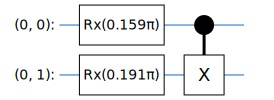

In [208]:
SVGCircuit(qks_ansatz._ansatz(tf.convert_to_tensor([0.5, 0.6])))

In [43]:
class QuantumKitchenSinks:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
    
    @tf.function
    def _custom_accuracy(self, y_true, y_pred):
        y_true = tf.squeeze(y_true)
        y_pred = tf.map_fn(lambda x: 1.0 if x >= 0.0 else -1.0, y_pred)
        return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))
    
    def _mnist_model_compile(self, learning_rate=0.05):
        cluster_state_bits = cirq.GridQubit.rect(1,2)
        readout_operators = [cirq.Z(cluster_state_bits[0], cirq.Z(cluster_state_bits[1]))]
        
        inputs = tf.keras.

In [209]:
mnist_data = MNISTData(seed)
X_train, X_test, y_train, y_test = mnist_data.get_three_five_test_train_split()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(12108, 784) (1346, 784) (12108,) (1346,)


In [211]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [212]:
x_train.shape

(60000, 28, 28)

In [213]:
x_train = np.reshape(x_train, (-1, 784))

In [214]:
x_train.shape

(60000, 784)